# TM10007 Group 4 -- ECG Data
Lara de Bats (5022037), Josefien van den Berg (4663381), Merel Goossens (4856902), Amber Liqui Lung (4464168)

In this assignment we wil test certain classifiers in order to create a classifier model to distinguish between normal and abnormal ECG's. The code is divided in different sections that are explained in the corresponding method sections in our report. 

WARNING running section 3 takes about 2.5 hours. All the results of section 3 are also in the report. The code is written in such a way that you only need to run 'loading packages' and the code blocks in section 1 in order to be able to run the final model (last codeblock of section 4). Make sure you then use the function final_pipeline and NOT final_pipeline_usingresults. This last one uses the direct results from section 3 (used during practice runs), while the first one has the final pipeline manually entered. 

In [1]:
# Loading packages
import zipfile
import os
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC #,LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, make_scorer, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from IPython.display import display

pd.set_option('display.max_rows', 30)

## 1. Data loading, initial split, exploring and cleaning

Below we load the ECG data, convert it to a dataframe an clean the data.First we are going to start with loading the CS file into a dataframe. Then we are going to split the dataset into test data and training data.

In [2]:
# Load CSV file into dataframe
!git clone https://github.com/JosefienBerg/TM10007_ML_ECG_group4.git

with zipfile.ZipFile('/content/TM10007_ML_ECG_group4/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/TM10007_ML_ECG_group4/ecg')

df = pd.read_csv('/content/TM10007_ML_ECG_group4/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(df.index)}')
print(f'The number of columns: {len(df.columns)}')

Cloning into 'TM10007_ML_ECG_group4'...
remote: Enumerating objects: 481, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 481 (delta 77), reused 52 (delta 16), pack-reused 337
Receiving objects: 100% (481/481), 102.93 MiB | 15.50 MiB/s, done.
Resolving deltas: 100% (257/257), done.
The number of samples: 827
The number of columns: 9001


Underneath we explore our dataset

In [3]:
# How many patients have a normal or abnormal ECG?
count0= (df['label'] == 0).sum()
count1= (df['label'] == 1).sum()
print(f'There are {count0} patients with label 0')
print(f'There are {count1} patients with label 1')
# Since the majority of patients has no abnormalities we can conclude that label 0 is normal and label 1 is abnormal 

There are 681 patients with label 0
There are 146 patients with label 1


Now we will perform our initial split

In [4]:
# Split the whole data set in a training and test set
rs = 1 #Define random state for the entire last run
features = df.loc[:, df.columns !="label"].to_numpy()
labels = df["label"].to_numpy()

x_train, x_test, y_train, y_test = train_test_split (features, labels, train_size = 0.8, random_state = rs) 

Lets explore x_train

In [5]:
# Look at the size
print(f"The training set has {x_train.shape[0]} samples and {x_train.shape[1]} features with {y_train.shape[0]} labels")
print(f"The test has {x_test.shape[0]} samples and {x_test.shape[1]} features with {y_test.shape[0]} labels")

# Look at the number of label 1 and label 0 in trainingset
count0= (y_train == 0).sum()
count1= (y_train == 1).sum()
print(f'There are {count0} patients with label 0')
print(f'There are {count1} patients with label 1')

# Look at the distribution
df = pd.DataFrame(x_train)
display(df.describe())

# Look at the type of data
print(x_train.dtype)

The training set has 661 samples and 9000 features with 661 labels
The test has 166 samples and 9000 features with 166 labels
There are 548 patients with label 0
There are 113 patients with label 1


,0,1,2,3,4,5,6,7,8,9,...,8990,8991,8992,8993,8994,8995,8996,8997,8998,8999
count,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,...,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000
mean,478.717204,69.823105,41.238949,31.321235,33.833155,43.113152,54.780800,40.032242,28.325063,22.638780,...,0.290519,0.302100,0.294978,0.305415,0.304264,0.286087,0.295637,0.287318,0.286327,0.305670
std,1106.964043,186.046585,87.274245,64.930462,61.821562,50.042312,63.715797,56.426110,45.517731,38.289976,...,0.714486,0.971315,0.745781,0.963491,1.039575,0.689670,0.824740,0.789198,0.720865,0.998977
min,0.044655,0.338026,0.374062,0.392388,0.442473,0.468230,0.291254,0.181994,0.168997,0.732216,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.085808,6.768979,7.502202,7.918228,9.237540,13.226181,17.047453,11.637719,8.091135,6.875121,...,0.083780,0.079485,0.083381,0.082520,0.077617,0.083157,0.086061,0.076691,0.073960,0.079557
50%,11.151767,14.768699,16.251970,15.269568,17.957884,25.791952,39.496065,24.173781,15.300081,13.118000,...,0.142454,0.140542,0.146687,0.139903,0.139307,0.132732,0.144973,0.133659,0.137710,0.137780
75%,402.343527,48.932465,37.809844,28.695744,33.682866,54.209787,75.923461,49.275831,29.250552,24.233970,...,0.257732,0.254770,0.273020,0.258539,0.239875,0.248405,0.269031,0.261145,0.249522,0.250784
max,9510.877805,2022.415412,963.283307,805.184140,1016.707977,487.321980,1051.557893,775.236262,483.852043,548.180243,...,13.688973,21.448361,14.898771,21.244593,23.028723,9.810213,17.188242,15.990963,12.114080,21.667875


float64


As a last step, we want do delelte entire rows and columns with only zeros or NaN/None values as they can be seen as missing data.

In [6]:
#Delete rows and columns with only zero's or NaN's
def delete_missing_rows(x, y):
  concat = np.c_[x, y]

  for row in x:
    index = np.where((row == 0).all) or np.where((row == np.nan).all)
    np.delete(concat, index, 0)
  
  x =  concat[:,:-1]
  y = concat[:,-1] 
  return x, y

x_train, y_train = delete_missing_rows(x_train, y_train)

## 2. Data preprocessing
In this section we explore the data preprocessing steps before implementing them in the pipelines in section 3. Here we manually create the pipelines in order to test if the functions work and to determine the prinicpal components for PCA. 


**2.1 Imputation**; 
Underneath we try out the functions for the imputation steps. Datasets with missing values that are filled with placeholders such as NaN and None, can cause problems when using estimators. Therefore you want to perform imputation in order to create usable datasets. 

In [7]:
#Replace nan's and zeros since the chance of a zero is very low due to only float types
def replace_missing_values(x): 
  """This function replaces all missing values"""
  imp = SimpleImputer(missing_values = np.nan, strategy='mean')
  x_new = imp.fit_transform(x, y=None) #removes entire columns if it contains only missing values

  imp = SimpleImputer(missing_values = 0, strategy='mean')
  x_new = imp.fit_transform(x, y=None) #removes entire columns if it contains only missing values
  return x_new

# Call functions to perform imputation steps and rename x_train
x_train_imp = replace_missing_values(x_train)

count0= (x_train_imp == 0).sum() 
countNaN = np.isnan(x_train_imp)[np.isnan(x_train_imp) == True].size
print(f"There are {count0} zeros and {countNaN} NaN values left in the dataset")

There are 0 zeros and 0 NaN values left in the dataset


**2.2 Feature scaling**; Underneath we try the chosen scaling methods Robust and MinMax

In [8]:
# 1. Min-max scaling
scaler_minmax = MinMaxScaler()
x_scaled_minmax = scaler_minmax.fit_transform(x_train_imp)

# 2. Robust scaling 
scaler_robust= RobustScaler()
x_scaled_robust = scaler_robust.fit_transform(x_train_imp)

x_scaled = {"minmax":x_scaled_minmax, "robust":x_scaled_robust}

**2.3 Feature Extraction**; Now we are going to investigate the n_components for the possible usage of PCA

minmax


AttributeError: ignored

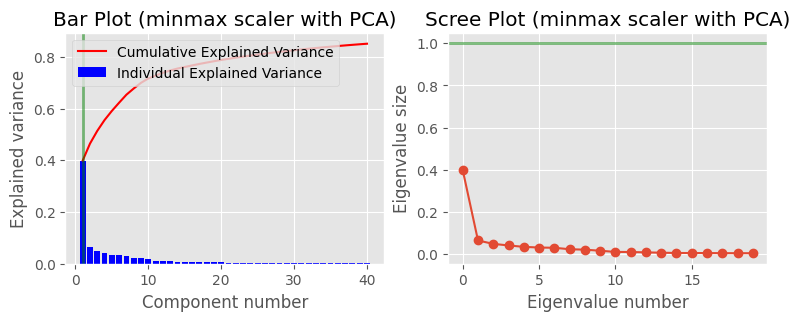

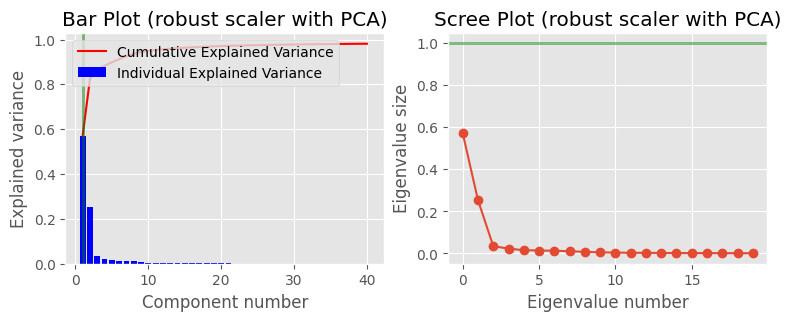

In [17]:
# PCA
plt.close('all') #before plotting, close all old windows
x_scaled_pca = {} #create dictionary to add all combinations of scaling combined with PCA to

### Testing the plotting method (elbow curve) ###

for key, x in x_scaled.items():

    # Determine amount of Principal Components for pipeline with PCA and one of the scalers
    pca_test = PCA(n_components =  None, random_state = rs)
    pca_test.fit(x)
    variance = pca_test.explained_variance_ratio_
    
    # Bar plot for the pipeline with PCA and one of the scalers
    g = plt.figure()
    plt.style.use("ggplot")
    g.set_figwidth(14)
    g.set_figheight(3)
    variance=variance[:40] # determine range for visualisation  
    plt.subplot(1, 3, 1) 
    plt.bar(range(1,len(variance )+1), variance, label = "Individual Explained Variance", color = 'blue')
    plt.ylabel('Explained variance')
    plt.xlabel('Component number')
    plt.plot(range(1,len(variance )+1),
         np.cumsum(variance),
         c='red',
         label="Cumulative Explained Variance"
          ) 
    plt.axvline(x=1, linewidth=2, color='green', alpha=0.5) #Kaiser's rule
    plt.legend(loc='upper left')
    plt.title(f"Bar Plot ({key} scaler with PCA)")

    # Scree plot the pipeline with PCA and one of the scalers
    plt.subplot(1, 3, 2)
    plt.style.use("ggplot") 
    plt.plot(variance[0:20], marker='o')
    plt.axhline(y=1, linewidth=2, color='green', alpha=0.5) #Kaiser's rule
    plt.xlabel("Eigenvalue number")
    plt.ylabel("Eigenvalue size")
    plt.title(f"Scree Plot ({key} scaler with PCA)")


### Applying the final pca method ###

def get_pca_components(X):
        
    for n in range(101,301,10):
      
      # create the needed variables 
      pca = PCA(n_components=n)
      principal_components = pca.fit_transform(X)
      cumm_var = pca.explained_variance_ratio
      
      print(f'{n} components corresponds to {sum(cumm_var)} of the total explained variation')
      
      # check whether the threshold is exceded
      if sum(cumm_var) >= 0.95:
        break 
  
      return cumm_var, principal_components

# plot to show treshold choice
for key, x in x_scaled.items():
    print(key)
    
    get_pca_components(x)

    plt.rcParams["figure.figsize"] = (12,6)

    fig, ax = plt.subplots()
    xi = np.arange(1, 662, step=1)
    y = np.cumsum(cumm_var)

    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='o', linestyle='--', color='b')

    plt.xlabel('Number of Components')
    plt.xticks(np.arange(0, 661, step=50)) #change from 0-based array index to 1-based human-readable label
    plt.ylabel('Cumulative variance (%)')
    plt.title(f'The number of components needed to explain variance for scaling method {key}')

    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.text(0.5, 0.9, '95% cut-off threshold', color = 'red', fontsize=16)

    plt.axhline(y=0.85, color='r', linestyle='-')
    plt.text(0.5, 0.8, '85% cut-off threshold', color = 'red', fontsize=16)

    plt.axhline(y=0.75, color='r', linestyle='-')
    plt.text(0.5, 0.7, '75% cut-off threshold', color = 'red', fontsize=16)

    ax.grid(axis='x')
    plt.show()



# ## methode die misgaat##

# for key, x in x_scaled.items():
#     pca = PCA().fit(x)
#     n_components = get_pca_components(pca,0.95)

#     pca_setting = PCA(n_components = 0.95, svd_solver = 'full', random_state = rs) # threshold at 95% method
#     x_pca = pca_setting.fit_transform(x)
#     x_scaled_pca[f"x_{key}_PCA"] = x_pca

#     # plot to show treshold choice
#     pca_figure = PCA().fit(x)
#     plt.rcParams["figure.figsize"] = (12,6)

#     fig, ax = plt.subplots()
#     xi = np.arange(1, 662, step=1)
#     y = np.cumsum(pca_figure.explained_variance_ratio_)

#     plt.ylim(0.0,1.1)
#     plt.plot(xi, y, marker='o', linestyle='--', color='b')

#     plt.xlabel('Number of Components')
#     plt.xticks(np.arange(0, 661, step=50)) #change from 0-based array index to 1-based human-readable label
#     plt.ylabel('Cumulative variance (%)')
#     plt.title(f'The number of components needed to explain variance for scaling method {key}')

#     plt.axhline(y=0.95, color='r', linestyle='-')
#     plt.text(0.5, 0.9, '95% cut-off threshold', color = 'red', fontsize=16)

#     plt.axhline(y=0.85, color='r', linestyle='-')
#     plt.text(0.5, 0.8, '85% cut-off threshold', color = 'red', fontsize=16)

#     plt.axhline(y=0.75, color='r', linestyle='-')
#     plt.text(0.5, 0.7, '75% cut-off threshold', color = 'red', fontsize=16)

#     ax.grid(axis='x')
#     plt.show()

In [ ]:
# pca_setting = PCA(n_components = 0.95, random_state = rs) # threshold at 95% method
# x_pca = pca_setting.fit_transform(x_scaled["robust"])

# x_select_test = SelectKBest().fit_transform(x_pca, y_train)
# print(x_select_test)
# print(x_select_test.shape[1])

# x_SMOTE = SMOTE(sampling_strategy = 'minority', random_state = rs).fit_resample(x_select_test, y_train)
# print(x_SMOTE)

print(x_scaled_pca["x_robust_PCA"].shape[1])
print(x_scaled_pca["x_minmax_PCA"].shape[1])

11
165


**2.4 Feature Selection**; For feature selection, the SelectKBest is used as explained in the method, this is as standard function directly implemented in the pipelines in the next section.

**2.5 Creating pipelines**; this step is performed in the next section combined with directly adding the SMOTE and classifiers in the models_all_combinations dictionary.

## 3. Classifiers: hyperparameter tuning and fitting
In this section we will build a neural network and train our different clasiffiers (standard and the neural network) and compare their functionality in terms of F1 and AUC. The accuracy is also provided to see if we are still close to the 82% when randomly pikking. We will perform this for all possible combinations of scaling, selection and classification possibilities. This is also the section were we will tune our parameters.

WARMING: Running this code takes approximately 2.5 hours. 

First we are going to set the pipelines and parameters we are going to tune and write the function for tuning. 

In [ ]:
# Creating a dictionary of all proposed pipelines
#GaussianNB and LinearSVC are removed from these dictionary's

models_all_combinations = {"minmax_pca_ffs":{
          "GaussianNB":Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()), ("scaler", MinMaxScaler()), ("pca", PCA()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', GaussianNB())]),
          "KNeighborsClassifier": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()), ("scaler", MinMaxScaler()), ("pca", PCA()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', KNeighborsClassifier())]),
          "RandomForestClassifier": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", MinMaxScaler()), ("pca", PCA()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', RandomForestClassifier())]),
          "SVC": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", MinMaxScaler()), ("pca", PCA()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c',SVC())]),
          "MLP": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", MinMaxScaler()), ("pca", PCA()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', MLPClassifier())])},
          
          "robust_pca_ffs":{
              "GaussianNB":Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()), ("scaler", RobustScaler()), ("pca", PCA()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', GaussianNB())]),    
              "KNeighborsClassifier": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", RobustScaler()), ("pca", PCA()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', KNeighborsClassifier())]), 
              "RandomForestClassifier": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", RobustScaler()), ("pca", PCA()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', RandomForestClassifier())]),
              "SVC": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", RobustScaler()), ("pca", PCA()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c',SVC())]),
              "MLP": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", RobustScaler()), ("pca", PCA()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', MLPClassifier())])},
              
          "minmax_ffs":{
              "GaussianNB":Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()), ("scaler", MinMaxScaler()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', GaussianNB())]),   
              "KNeighborsClassifier": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", MinMaxScaler()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', KNeighborsClassifier())]),
              "RandomForestClassifier": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", MinMaxScaler()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', RandomForestClassifier())]),
              "SVC": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", MinMaxScaler()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c',SVC())]),
              "MLP": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", MinMaxScaler()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', MLPClassifier())])},
          
          "robust_ffs":{
              "GaussianNB":Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()), ("scaler", RobustScaler()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', GaussianNB())]), 
              "KNeighborsClassifier": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", RobustScaler()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', KNeighborsClassifier())]), 
              "RandomForestClassifier": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", RobustScaler()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', RandomForestClassifier())]),
              "SVC": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", RobustScaler()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c',SVC())]),
              "MLP": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", RobustScaler()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', MLPClassifier())])}
              }

# Creating a dictionary of all parameters
k = 10
nc = 0.95 #Set n_components for PCA

model_parameters = {"GaussianNB":{},
                    "KNeighborsClassifier":{"c__n_neighbors":[x for x in range(1, 400)], "c__weights": ["distance", "uniform"]},
                    "RandomForestClassifier":{"c__n_estimators":[x for x in range(2,100)], "c__max_depth":[x for x in range (1,60)], "c__min_samples_leaf": [x for x in range (20, 300)], "c__random_state" : [rs]},
                    "SVC":{"c__C": [x for x in np.arange(0.00000001, 1, 0.00000001)], "c__kernel": ["rbf", "poly"], "c__degree":[x for x in range (2,4)], "c__random_state" : [rs]},
                    "MLP": {"c__hidden_layer_sizes": [10,300,600], "c__activation": ["relu", "logistic", "tanh"], "c__solver": ["sgd", "adam", "lbfgs"], 
                            "c__learning_rate": ["constant", "adaptive"], "c__max_iter":[100], "c__random_state" : [rs], "c__early_stopping": [True]}
                    }  

param_with_PCA = {"imp0__missing_values": [0], "pca__n_components" : [nc], "pca__svd_solver": ["full"], "pca__random_state": [rs], "selector__k": [k], "sampling__sampling_strategy": ["minority"], "sampling__random_state":[rs]}  
param_without_PCA = {"imp0__missing_values": [0], "selector__k": [k], "sampling__sampling_strategy": ["minority"], "sampling__random_state":[rs]}      

Now we are going to write the functions to execute the Randomized search, return the needed results for the validation plots and plot the loss curves for the MLP classifier. Here we also directly calculate the outer cross-validation scores that will be dipslayed in section 5.

In [ ]:
# Function to clean up results and create dataframe with wanted results
def get_dataframe_from_results(results, scorer):
  """ This function makes sure that we can clean up the results that we get from the randomized search and leaves us with the necessary results"""
  df_to_concat = [pd.DataFrame(results["params"])]

  for key in scorer:
    df_to_concat.append(pd.DataFrame(results[f"mean_train_{key}"], columns=[f"mean_train_{key}"]))
    df_to_concat.append(pd.DataFrame(results[f"mean_test_{key}"], columns=[f"mean_test_{key}"]))

  return pd.concat(df_to_concat, axis=1)

# Function to do a grid search on each model using the parameters in the model_parameter dictionary
def parametertuning(CombinationName, Models, ModelParameters, n_splits, n_iter, random_state, scorer, refit, X, Y):
  """ This function performs the parameter tuning by doing a randomized search with multiple parameters per model. It returns the results that are cleaned up, calculates the outer cross validation scores and plots the MLP loss curves"""
  results = {} #create a dictionary to save results

  for model_name, parameters in ModelParameters.items():
    print(f"Randomized searching {model_name}")
    model = Models[model_name]  # Find corresponding model in models dict

    # Add constant parameters to the 
    if 'pca' in CombinationName:
      params_complete = {**param_with_PCA, **parameters}
    else:
      params_complete = {**param_without_PCA, **parameters}

    # Create the cross validation object for inner and outer cross validation
    cv_inner = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    cv_outer = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)   
    
    # Perform a randomized search for the best parameters for the model using the test data and KFold
    randomized_search = RandomizedSearchCV(model, params_complete, cv=cv_inner, n_iter=n_iter, n_jobs=-1, verbose=False, scoring=scorer, refit=refit, return_train_score=True, random_state = random_state, error_score = 'raise') 
    randomized_search.fit(X, Y)

    # Results of randomized search
    best_estimator = randomized_search.best_estimator_ # Returns the model with the best parameters filled in based on refit scoring metric
    best_params = randomized_search.best_params_ 
    best_score = randomized_search.best_score_
    randomized_search_results = get_dataframe_from_results(randomized_search.cv_results_, scorer) # Extracts the necessary results 

    #Compute the outer cross validation scores to compare models (also the accuracy to see if we still are above the 85% in the assignment)
    a_outer = np.mean(cross_val_score(best_estimator, X, Y, cv=cv_outer)) 
    f1_outer = np.mean(cross_val_score(best_estimator, X, Y, cv=cv_outer, scoring = scorer["F1"])) 
    AUC_outer = np.mean(cross_val_score(best_estimator, X, Y, cv=cv_outer, scoring = scorer["AUC"])) 

    # Add the results to the dictionary
    results[model_name] = {"BestEstimator": best_estimator, "BestParams":best_params, "BestScore":best_score, "Accuracy_outer":a_outer, "F1_outer":f1_outer, "AUC_outer":AUC_outer, "GSresults": randomized_search_results}
  
  return results

Now we are going write the function to plot the validation curves to estimate if we are giving the randomized search the correct ranges.

In [ ]:
# Functions to create validation plots and loss curve

#---------------Plot for KNeighborsClassifier---------------
def plot_knn(results, scoring, combination_name, ModelParameters):
  """This function plots the validation curves for all pipeline combinations for the KNeighborsClassifier"""
  knn_df = results["KNeighborsClassifier"]["GSresults"]
  uni_knn_df = knn_df[knn_df["c__weights"] == "uniform"]
  dist_knn_df = knn_df[knn_df["c__weights"] == "distance"]

  fig, ax = plt.subplots(2,2) #create subplot
  fig.suptitle(f"KNN validation plots for {combination_name}", fontsize=12)

  # For uniform weight
  grouped_n = uni_knn_df.groupby(by=["c__n_neighbors"]).mean()
  param_list = grouped_n.index.to_numpy()  # Pakt de parameters die op de x as gezet worden

  for score, i in zip(scoring, range(0,2)): 
    ax[i,0].plot(param_list, grouped_n[f"mean_train_{score}"], label="Train")  # plot the train F1 score
    ax[i,0].plot(param_list, grouped_n[f"mean_test_{score}"], label=f"Test")  # plot the test F1 score
    ax[i,0].set_title(f"Uniform {score}")
    ax[i,0].set_xlabel(f"n_neighbors")
    ax[i,0].set_ylabel(f"{score}")
    ax[i,0].legend(loc='lower right')

  # For distance weight
  grouped_n = dist_knn_df.groupby(by=["c__n_neighbors"]).mean()
  param_list = grouped_n.index.to_numpy()  # Pakt de parameters die op de x as gezet worden

  for score, i in zip(scoring, range(0,2)): 
    ax[i,1].plot(param_list, grouped_n[f"mean_train_{score}"], label="Train")  # plot the train F1 score
    ax[i,1].plot(param_list, grouped_n[f"mean_test_{score}"], label="Test")  # plot the test F1 score
    ax[i,1].set_title(f"Distance {score}")
    ax[i,1].set_xlabel(f"n_neighbors")
    ax[i,1].set_ylabel(f"{score}")
    ax[i,1].legend(loc='lower right')

  
  for ax in fig.get_axes():
    ax.label_outer()
  
#---------------Plot for SVC Classifier--------------- 
def plot_svc(results, scoring, combination_name, ModelParameters):
  """This function plots the validation curves for all pipeline combinations for the SVCClassifier"""
  svc_df = results["SVC"]["GSresults"]
  rbf_svc_df = svc_df[svc_df["c__kernel"]=="rbf"]
  poly_svc_df = svc_df[svc_df["c__kernel"]=="poly"]

  fig, ax = plt.subplots(2,3) #create subplot
  fig.suptitle(f"SVC validation plots for {combination_name}", fontsize=12)

  # For RBF kernel
  grouped_C = rbf_svc_df.groupby(by=["c__C"]).mean()
  param_list = grouped_C.index.to_numpy()  # Pakt de parameters die op de x as gezet worden

  for score, i in zip(scoring, range(0,2)): 
    ax[i,0].plot(param_list, grouped_C[f"mean_train_{score}"], label="Train")  # plot the train F1 score
    ax[i,0].plot(param_list, grouped_C[f"mean_test_{score}"], label="Test")  # plot the test F1 score
    ax[i,0].set_title(f"RBF {score}")
    ax[i,0].set_xlabel(f"C")
    ax[i,0].set_ylabel(f"{score}")
    ax[i,0].set_xscale('log')
    ax[i,0].legend(loc='lower right')
    
  #For Poly kernels 
  for degree, i in zip(range(2,4), range(1,3)):
    degree_svc_df = poly_svc_df[poly_svc_df["c__degree"]==degree]
    grouped_C = degree_svc_df.groupby(by=["c__C"]).mean()
    param_list = grouped_C.index.to_numpy()  # Pakt de parameters die op de x as gezet worden

    for score, j in zip(scoring, range(0,2)): 
      ax[j,i].plot(param_list, grouped_C[f"mean_train_{score}"], label="Train")  # plot the train F1 score
      ax[j,i].plot(param_list, grouped_C[f"mean_test_{score}"], label="Test")  # plot the test F1 score
      ax[j,i].set_title(f"Poly degree {degree} {score}")
      ax[j,i].set_xlabel(f"C")
      ax[j,i].set_ylabel(f"{score}")
      ax[j,i].set_xscale('log')
      ax[j,i].legend(loc='lower right')

  for ax in fig.get_axes():
    ax.label_outer()
       
# ---------------Plot for RandomForestClassifier---------------
def plot_randomforest(results, scoring, combination_name, ModelParameters):
  """This function plots the validation curves for all pipeline combinations for the RandomForestClassifier"""
  forest_df = results["RandomForestClassifier"]["GSresults"]

  fig, ax = plt.subplots(2,3) #create subplot
  fig.suptitle(f"Decision tree validation plots for {combination_name}", fontsize=12)
  
  for param, j in zip(ModelParameters["RandomForestClassifier"], range(0,3)):
    grouped = forest_df.groupby(by=[param]).mean()
    param_list = grouped.index.to_numpy()  # Pakt de parameters die op de x as gezet worden
    
    for score, i in zip(scoring, range(0,2)): 
      ax[i,j].plot(param_list, grouped[f"mean_train_{score}"], label="Train")  # plot the train F1 score
      ax[i,j].plot(param_list, grouped[f"mean_test_{score}"], label="Test")  # plot the test F1 score
      ax[i,j].set_title(f"{param.replace('c__', '')}")
      ax[i,j].set_xlabel(f"{param.replace('c__', '')}")
      ax[i,j].set_ylabel(f"{score}")
      ax[i,j].legend(loc='lower right')
  
  for ax in fig.get_axes():
    ax.label_outer()

# ---------------Plot for MLP loss curve---------------
def plot_MLP(results_all_combinations):
  fig, ax = plt.subplots(4,1)
  fig.suptitle(f"MLP loss scores for all four pipelines", fontsize=12)

  for combination_name, i in zip(results_all_combinations, range(0,4)):
    loss_values = results_all_combinations[combination_name]["MLP"]["BestEstimator"].named_steps["c"].loss_curve_

    ax[i].plot(loss_values)
    ax[i].set_title(f"{combination_name}")
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Loss')

  for ax in fig.get_axes():
    ax.label_outer()

Lastly, we will call all functions written to tune all the parameters and plot the results for each combination of scaling, PCA and selection.

In [ ]:
# Perform training and plot MLP loss curve
results_all_combinations = {}

for combination_name, models in models_all_combinations.items():

  #Create scorers
  f1_scorer = make_scorer(f1_score, labels = None, average = 'binary', pos_label = 1) 
  scoring = {"F1":f1_scorer, "AUC":"roc_auc"} #Determine what type of scoring you want to use
  
  #Ignorme warnings from MLP
  import warnings
  warnings.filterwarnings('ignore') 

  # Perform randomized search (rs= ramdom state that is previously defined)
  results = parametertuning(combination_name, models, model_parameters, 5, 50, rs, scoring, "F1", x_train, y_train)
  results_all_combinations[combination_name] = results

Randomized searching GaussianNB
Randomized searching KNeighborsClassifier
Randomized searching RandomForestClassifier
Randomized searching SVC
Randomized searching MLP
Randomized searching GaussianNB


ValueError: ignored

In [ ]:
# Create validation curves
plt.close('all') #make sure you class all windows before plotting to prevent plotting in the same figure

for combination_name in models_all_combinations:
  plot_knn(results_all_combinations[combination_name], scoring, combination_name, model_parameters)
  plot_svc(results_all_combinations[combination_name], scoring, combination_name, model_parameters)
  plot_randomforest(results_all_combinations[combination_name], scoring, combination_name, model_parameters)

#Create MLP loss curve  
plot_MLP(results_all_combinations)

## 4. Modal comparison, final model and testing
In this section we will determine our final model setup based on tables created with the different results. We will then test the final model setup in the pipeline on the test data. If you want to only see the final pipeline with results, the code is written in such a way that you only need to to run section 1 and the last code block of this section with the function final_pipeline on.

Beneath, we write and execute the function to display the best scoring results for each model.

In [ ]:
# Write function to plot table. 
def create_table_of_results(results_all_combinations, combination_name):
  """This function plots a table containing the model names, best paramete combination, best inner F1 score that is used to choose the BestEstimator and the outer cross validation scores"""
  model_names = [] 
  best_params = []
  best_scores = []
  Mean_Accuracy = []
  Mean_F1 = []
  Mean_AUC = []

  results = results_all_combinations[combination_name]

  for model_name in results:

    # Create column with model names
    model_names.append(model_name)

    # Create column with best params
    best_param = results[model_name]["BestParams"]
    best_params.append(best_param)

    # Create column with best inner score
    best_score = results[model_name]["BestScore"]
    best_scores.append(best_score)
    
    # Create column with accuracy scores of outer cross validation of best estimator
    mean_accuracy = results[model_name]["Accuracy_outer"]
    Mean_Accuracy.append(mean_accuracy)

    # Create column with accuracy scores of outer cross validation of best estimator
    mean_f1 = results[model_name]["F1_outer"]
    Mean_F1.append(mean_f1)
    
    # Create column with accuracy scores of outer cross validation of best estimator
    mean_AUC = results[model_name]["AUC_outer"]
    Mean_AUC.append(mean_AUC)

  print(f"Table of results for combination {combination_name}")
  display(pd.DataFrame({"ModelName":model_names, "Outer accuracy of BE":Mean_Accuracy, "Outer F1 of BE":Mean_F1, "Outer AUC of BE":Mean_AUC}).style.hide(axis='index'))
  print("\n")

# Create table with results for every combination
for combination_name in models_all_combinations:
  create_table_of_results(results_all_combinations, combination_name)

In [ ]:
# Write final pipeline with chosen combinations
def final_pipeline_usingresults(results_all_combinations, x_test, y_test):
    """This function goes trough all the steps of the final model setup chosen in the previous section. Note: you need to run sections loading packages, 1 and 3 in order to run this code"""
    
    #Define pipeline when section 4 is runned
    pipe = results_all_combinations["minmax_ffs"]["SVC"]["BestEstimator"]
    print(f"The steps of the final model look are {pipe}\n")

    # Compute the scores of the model on the test data
    y_pred= pipe.predict(x_test)
    score_f1 = f1_score(y_test, y_pred)
    score_AUC = roc_auc_score(y_test, y_pred)
    score_accuracy = accuracy_score(y_test, y_pred)

    return score_f1, score_AUC, score_accuracy, y_pred

def final_pipeline(x_train, y_train, x_test, y_test):
    """This function goes trough all the steps of the final model setup chosen in the previous section. Note: you need to run sections loading packages and 1 in order to run this code"""

    # Define pipeline and fit pipeline when section 4 is not runned (manually typed best estimator pipeline from results section 4)
    pipe = Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer(missing_values=0)),("scaler", RobustScaler()), ("selector", SelectKBest()), ('sampling', SMOTE(sampling_strategy="minority")),('c',SVC(C=0.19978523))])
    pipe.fit(x_train, y_train)

    # Compute the scores of the model on the test data
    y_pred= pipe.predict(x_test)
    score_f1 = f1_score(y_test, y_pred)
    score_AUC = roc_auc_score(y_test, y_pred)
    score_accuracy = accuracy_score(y_test, y_pred)

    return pipe, score_f1, score_AUC, score_accuracy, y_pred


## Execute pipeline to get the scores of the final model on the test data
# pipe, score_f1, score_AUC, score_accuracy, y_pred = final_pipeline_usingresults(results_all_combinations, x_test, y_test) #Choose this option when section 3 is runned
# pipe, score_f1, score_AUC, score_accuracy, y_pred = final_pipeline(x_train, y_train, x_test, y_test) #Choose this option when section 3 is not runned

# print(f"The scores of the final model are: f1 = {score_f1}, AUC = {score_AUC} and accuracy = {score_accuracy}\n")

# #Create confusion matrix for discussion
# disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels= pipe.named_steps["c"].classes_, cmap = "binary")
# plt.grid(False)
# disp.ax_.set_title("Confusion matrix of the final model")